In [12]:
import numpy as np
import baseline_model
from casadi import *
import do_mpc
import decentralized as dec
import util
import sim_drone_main
from baseline_model import baseline_drone_model
from baseline_model_mpc import baseline_drone_mpc
from baseline_model_simulator import baseline_drone_simulator
import itertools
import time
import concurrent.futures

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
x_baseline_init, x_baseline_f = util.paper_setup_3_quads()

In [52]:
x_baseline1 = x_baseline_init

In [55]:
xf = x_baseline_f

In [56]:
xf.shape

(18, 1)

In [64]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

#x = p_x,p_y,p_z,v_x,v_y,v_z
#u = theta, phi, tau

#Concantenated states of all agents
x = model.set_variable(var_type='_x', var_name='x', shape=(18, 1))
#Concatenated inputs of all agents
u = model.set_variable(var_type='_u', var_name='u', shape=(9, 1))


g = 9.81
model.set_rhs('x', vertcat(x[3], x[4], x[5], g*np.tan(u[0]), -g*np.tan(u[1]), u[2]-g,\
                           x[9], x[10], x[11], g*np.tan(u[3]), -g*np.tan(u[4]), u[5]-g,\
                          x[15], x[16], x[17], g*np.tan(u[4]), -g*np.tan(u[5]), u[6]-g))


total_stage_cost = (x-xf).T@Q@(x-xf) + u.T@R@u 
total_terminal_cost = (x-xf).T@Qf@(x-xf)

model.set_expression('total_stage_cost',total_stage_cost)
model.set_expression('total_terminal_cost',total_terminal_cost)

radius = 0.5
#x_baseline is concatenated states of all agents
distances = util.compute_pairwise_distance_Sym(x_baseline1,x_dims,n_d=3) 
    
distances = SX(distances)
# prox_cost = sum1(SX(np.fmin(np.zeros(1), distances - radius) ** 2))
# model.set_expression('proximity_cost',prox_cost) 

model.set_expression('collision_constraint',distances)
    
#The prox_cost should be handled by a centralized processor since xf only contains the state
#a single agent
#Set this up in the mpc controller

model.setup()



In [66]:
mpc = do_mpc.controller.MPC(model)

setup_mpc = {
    'n_horizon': 5,
    'n_robust': 0,
    'open_loop': 0,
    't_step': 0.1,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 2,
    'collocation_ni': 2,
    'store_full_solution': True
}

mpc.set_param(**setup_mpc)

#We want the distances between each drone > 0.5
mpc.set_nl_cons('collision', -model.aux['collision_constraint'], -0.5, soft_constraint=True) 
#in this case we want the collision avoidance cost inccured to be 0, which means their 
#pairwise distances must be > radius
mterm = model.aux['total_terminal_cost']
lterm = model.aux['total_stage_cost']

mpc.set_objective(mterm=mterm,lterm=lterm)

max_input = np.array([[theta_max], [phi_max], [tau_max], \
                      [theta_max], [phi_max], [tau_max], \
                      [theta_max], [phi_max], [tau_max]])

mpc.bounds['lower', '_u', 'u'] = -max_input
mpc.bounds['upper', '_u', 'u'] = max_input

max_state = np.array([[6.5], [6.5], [6.5], [v_max],[v_max], [v_max],\
                      [6.5], [6.5], [6.5], [v_max],[v_max], [v_max],\
                      [6.5], [6.5], [6.5], [v_max],[v_max], [v_max]])

#v_max refers to the max velocity in each direction
#constraints on x,y,z position is set as 6.5 because the actual flying arena has a limited space
mpc.bounds['lower','_x', 'x'] = -max_state
mpc.bounds['upper','_x', 'x'] = max_state



mpc.setup()

# opt_labels = mpc.x.labels()
# labels_lb_viol =np.array(opt_labels)[np.where(lb_viol)[0]]
# labels_ub_viol =np.array(opt_labels)[np.where(lb_viol)[0]]

In [339]:

# lb_bound_violation = mpc.opt_x_num.cat
# opt_labels = mpc.opt_x.labels()
# labels_lb_viol =np.array(opt_labels)[np.where(lb_bound_violation)[0]]
# labels_lb_viol

In [470]:
data_baseline = np.load('drone_sim_data.npy')

In [471]:
dataSet = data_baseline
# print(dataSet)
dataSet = np.array(dataSet).T

In [472]:
dataSet.shape

(18, 21)

In [473]:
dataSet[0].shape

(21,)

In [474]:
%matplotlib ipympl

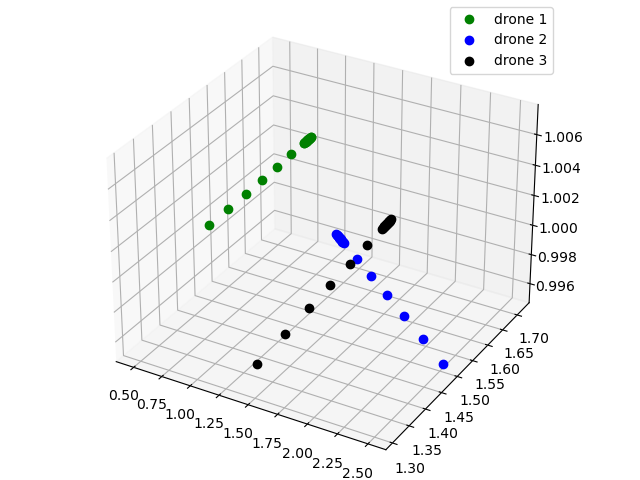

In [475]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

 
# GET SOME MATPLOTLIB OBJECTS
fig = plt.figure()
ax = Axes3D(fig,auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot(dataSet[0], dataSet[1], dataSet[2], 'go',label='drone 1')
ax.plot(dataSet[6], dataSet[7], dataSet[8], 'bo',label='drone 2')
ax.plot(dataSet[12], dataSet[13], dataSet[14], 'ko',label='drone 3')
ax.legend()
plt.title('Drone with nonlinear dynamics (6D)')
plt.savefig('original_drone.png')


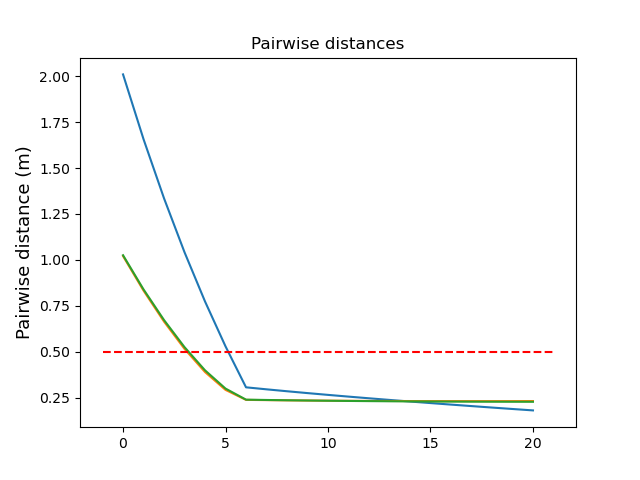

In [476]:
plt.figure()
plt.plot(dec.compute_pairwise_distance(dataSet.T, x_dims, 3))
plt.hlines(radius, *plt.xlim(), 'r', ls='--')
# plt.title('Distance between human and quad over entire horizon')
plt.ylabel('Pairwise distance (m)',fontsize=13)
plt.title('Pairwise distances')
plt.draw()

In [417]:
data_baseline[0]

array([0.496, 1.498, 1.015, 0.   , 0.   , 0.   , 2.513, 1.494, 1.007,
       0.   , 0.   , 0.   , 1.492, 1.295, 1.024, 0.   , 0.   , 0.   ])

In [418]:
data_baseline[-1]

array([ 1.799e+00,  1.511e+00, -3.377e-01,  2.354e+00,  5.913e-03,
       -3.607e+00,  1.208e+00,  1.490e+00, -1.671e+00, -2.358e+00,
       -1.907e-03, -7.068e+00,  1.496e+00,  2.226e+00, -1.588e+00,
        1.907e-03, -7.092e-01, -6.965e+00])